### Benchmark the runtime of the transition part in the forward-call

Proof empirically that a dense matrix multiplication forward call is faster than the sparse variant (on GPU).

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
from learnMSA import msa_hmm
from time import perf_counter
import itertools
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


def make_A(cell):
    return cell.transitioner.make_A()
    
def make_sparse_A(cell):
    return cell.transitioner.make_A_sparse()

def dense_matmul(F, A):
    return tf.matmul(F, A) 
    
def sparse_matmul(F, A):
    return tf.sparse.sparse_dense_matmul(F, A) 
    
# runs a benchmark that compares the speed of dense and sparse matrix multiplication
def run_benchmark(model_length,
                  make_A_callback,
                  mul_callback, 
                  batch_size=128, 
                  dtype = tf.float64,
                  num_reps=1):
    cell = msa_hmm.MsaHmmCell(model_length)
    cell.build(input_shape = [batch_size, msa_hmm.fasta.s])
    times = []
    @tf.function
    def mul_and_derive():
        with tf.GradientTape() as tape:
            A = make_A_callback(cell)
            num_states = tf.shape(A)[-1] 
            A = tf.cast(A, dtype)
            F = tf.random.uniform(shape=[batch_size, num_states], dtype=dtype)
            F /= tf.reduce_sum(F, -1, keepdims=True)
            #dummy recurrent forward call
            for _ in range(model_length): #assuming that model_length correlates with average_seq_length
                F = mul_callback(F, A)
                F /= tf.reduce_sum(F, -1, keepdims=True)
            F = tf.reduce_sum(F)
        grad = tape.gradient(F, cell.trainable_variables)
        return F, grad
            
    for _ in range(num_reps):
        t_start = perf_counter()
        try:
            F,grad = mul_and_derive()
            
            grad = dict(zip([name for name,_ in cell.transitioner.explicit_transition_kernel_parts[0]], grad))
            times.append(perf_counter() - t_start)
        except tf.errors.ResourceExhaustedError as e:
            print(f"OOM with model_length={model_length} and batch_size={batch_size}")
            return -1
    return np.mean(times)

<dtype: 'float32'> 32 20
<dtype: 'float32'> 32 70
<dtype: 'float32'> 32 120
<dtype: 'float32'> 32 170
<dtype: 'float32'> 32 220
<dtype: 'float32'> 32 270
<dtype: 'float32'> 32 320
<dtype: 'float32'> 32 370
<dtype: 'float32'> 32 420
<dtype: 'float32'> 32 470
<dtype: 'float32'> 128 20
<dtype: 'float32'> 128 70
<dtype: 'float32'> 128 120
<dtype: 'float32'> 128 170
<dtype: 'float32'> 128 220
<dtype: 'float32'> 128 270
<dtype: 'float32'> 128 320
<dtype: 'float32'> 128 370
<dtype: 'float32'> 128 420
<dtype: 'float32'> 128 470
<dtype: 'float32'> 512 20
<dtype: 'float32'> 512 70
<dtype: 'float32'> 512 120
<dtype: 'float32'> 512 170
<dtype: 'float32'> 512 220
<dtype: 'float32'> 512 270
<dtype: 'float32'> 512 320
<dtype: 'float32'> 512 370
<dtype: 'float32'> 512 420
<dtype: 'float32'> 512 470


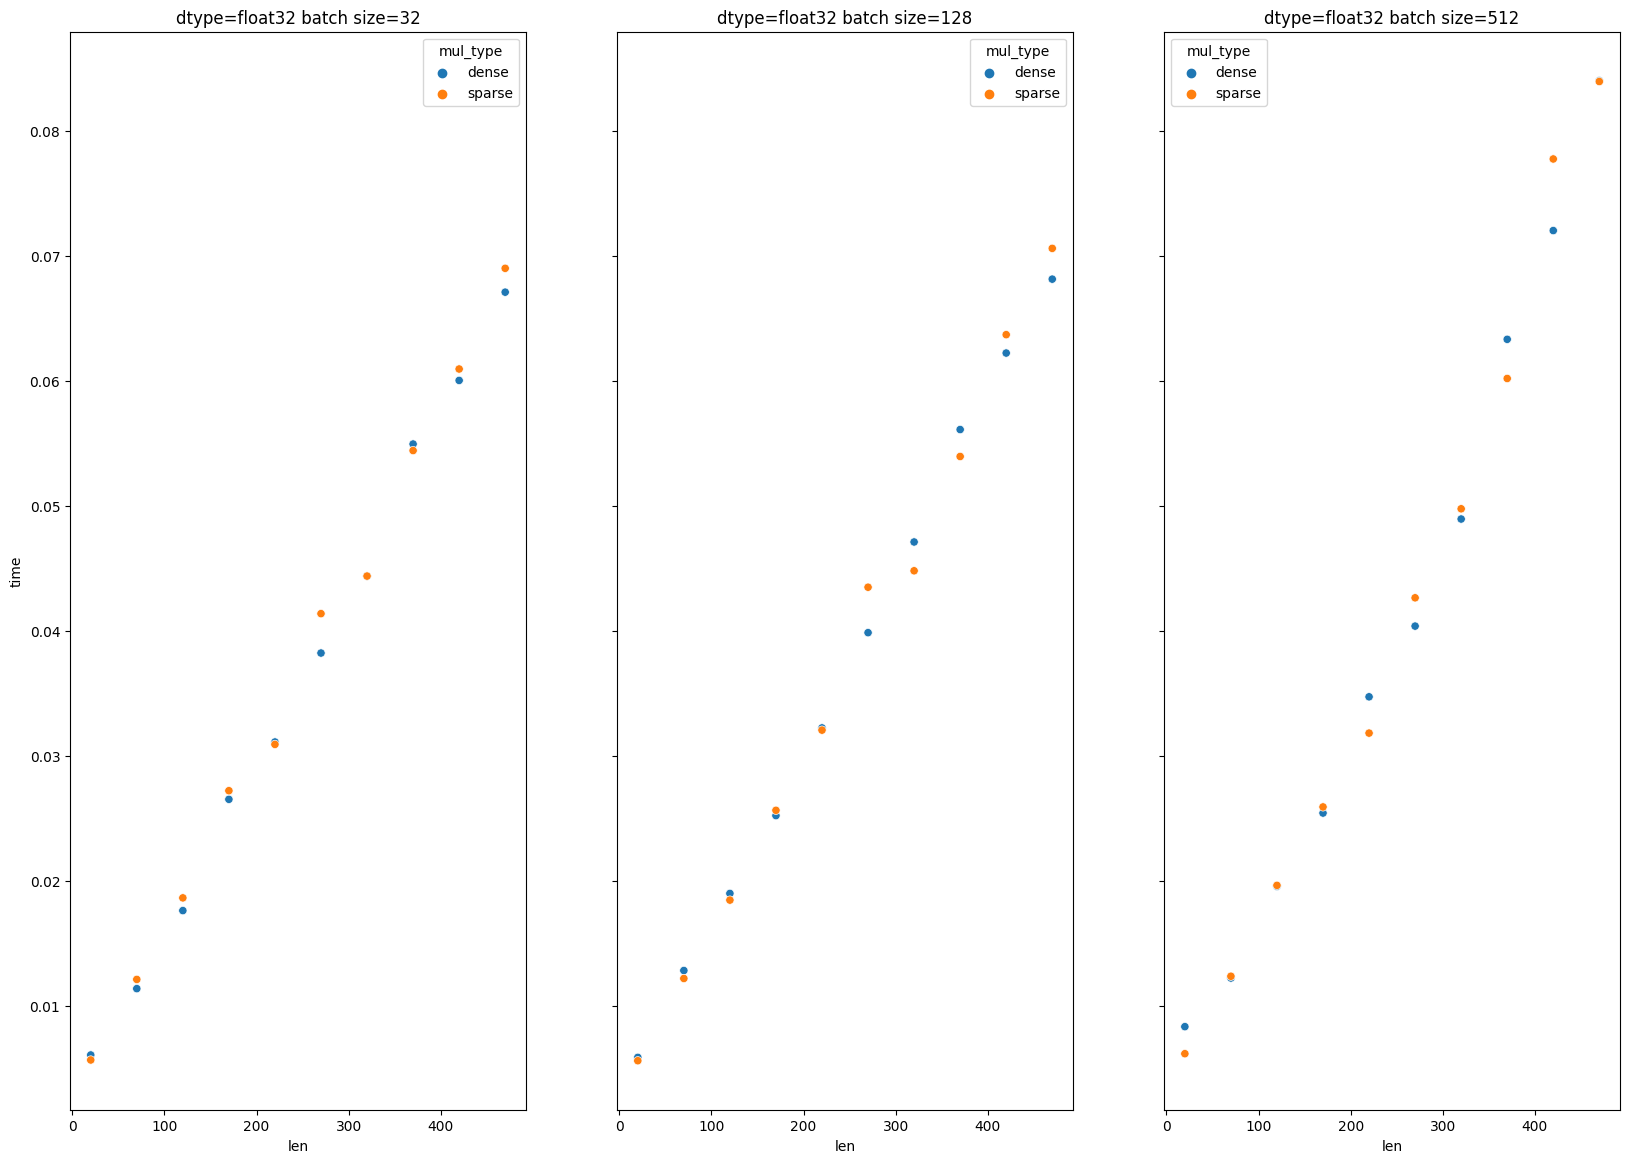

In [19]:
reps = 100
model_lengths = np.arange(10)*50+20
dtypes = [tf.float32]
batch_sizes = [32, 128, 512]
f, axes = plt.subplots(len(dtypes), len(batch_sizes), sharey=True)
f.set_size_inches(20, 14)
if len(dtypes)*len(batch_sizes) == 1:
    axes = [axes]
else:
    axes = axes.flatten()
    
def run_or_skip(times, model_length, make_A_callback, mul_callback, batch_size, dtype):
    if len(times) == 0 or times[-1] >= 0:
        dense = run_benchmark(model_length,
                              make_A_callback = make_A, 
                              mul_callback = dense_matmul,
                              batch_size=b,
                              dtype=d, 
                              num_reps=reps)
        return dense
    else:
        return -1
    
for ax,(d,b) in zip(axes, itertools.product(dtypes, batch_sizes)):
    dense_avg_times = []
    sparse_avg_times = []
    for model_len in model_lengths:
        print(d,b,model_len)
        dense = run_or_skip(dense_avg_times, model_len, make_A, dense_matmul, b, d)
        dense_avg_times.append(dense)
        sparse = run_or_skip(sparse_avg_times, model_len, make_sparse_A, sparse_matmul, b, d)
        sparse_avg_times.append(sparse)
    df = pd.DataFrame()
    for mul_type, times in [("dense", dense_avg_times), 
                            ("sparse", sparse_avg_times)]:
        type_df = pd.DataFrame()
        type_df["len"] = model_lengths
        type_df["time"] = times
        type_df["mul_type"] = mul_type
        df = pd.concat([df, type_df])
    df = df[df.time >= 0]
    title = f"dtype={d.name} batch size={b}"
    sns.scatterplot(data=df, x="len", y="time", hue="mul_type", ax=ax).set(title=title)